# News Recommendation System Project Comp9727

**Nama**: PanHang\
**zID**: z5598515\
**Email**: z5598515@ad.unsw.edu.au

Two news recommendation systems were constructed and evaluated, using the dataset MIND. The adopted methods include content-based filtering (using TF-IDF/ Bert) and collaborative filtering (based on the embedding model of pytorch). The evaluation method is Precision@K, based on the category matching degree of users' historical preferences.

# 1. Load Data

In [9]:
import os
import ast
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers

pd.set_option('display.max_columns', None)


In [52]:
#!pip install -U sentence-transformers # to load bert

In [10]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [12]:
behaviors = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/behaviors.tsv', sep='\t', 
                        names=["Impression_ID", "User_ID", "Time", "History", "Impressions"])

news = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/news.tsv', sep='\t',
                   names=["News_ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title_Entities", "Abstract_Entities"])


# 2. Data Preprocessing

In [13]:
news.head()

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [14]:
behaviors.head()

,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


### 2.1. Data Cleaning

In [16]:
def check_df_shape_and_null(df):
    print("The shape of df:", df.shape)
    df.info()
    
    print("\nThe number of missing values in each column:")
    print(df.isnull().sum())

check_shape_and_null(news)
check_shape_and_null(behaviors)

The shape of df: (51282, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            51282 non-null  object
 1   Category           51282 non-null  object
 2   SubCategory        51282 non-null  object
 3   Title              51282 non-null  object
 4   Abstract           48616 non-null  object
 5   URL                51282 non-null  object
 6   Title_Entities     51279 non-null  object
 7   Abstract_Entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB

The number of missing values in each column:
News_ID                 0
Category                0
SubCategory             0
Title                   0
Abstract             2666
URL                     0
Title_Entities          3
Abstract_Entities       4
dtype: int64
The shape of df: (156965, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 e

In [17]:
news_clean = news.dropna()
news_clean.drop_duplicates(subset=['News_ID'], inplace=True)

behaviors_clean = behaviors.dropna()
behaviors_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)

/tmp/ipykernel_35/676842085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean.drop_duplicates(subset=['News_ID'], inplace=True)
/tmp/ipykernel_35/676842085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviors_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)


dropna() is used to delete rows containing null values. This is particularly important in columns like Title, Abstract or Impressions, as this information is crucial in the process of content representation and label construction.

drop_duplicates() is used to remove duplicate entries based on News_ID in news.tsv and Impression_ID in drivs.tsv to avoid bias caused by duplicate data.

In [18]:
check_df_shape_and_null(news_clean)
check_df_shape_and_null(behaviors_clean)

The shape of df: (48612, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 48612 entries, 0 to 51280
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            48612 non-null  object
 1   Category           48612 non-null  object
 2   SubCategory        48612 non-null  object
 3   Title              48612 non-null  object
 4   Abstract           48612 non-null  object
 5   URL                48612 non-null  object
 6   Title_Entities     48612 non-null  object
 7   Abstract_Entities  48612 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB

The number of missing values in each column:
News_ID              0
Category             0
SubCategory          0
Title                0
Abstract             0
URL                  0
Title_Entities       0
Abstract_Entities    0
dtype: int64
The shape of df: (153727, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 153727 entries, 0 to 156964
Data columns (

## 2.2 Exploratory Data Analysis

The purpose is to better understand the data (the content of the news and user behavior)

So that the most suitable recommendation algorithm can be selected based on these features in the future, such as content recommendation or collaborative filtering, etc.

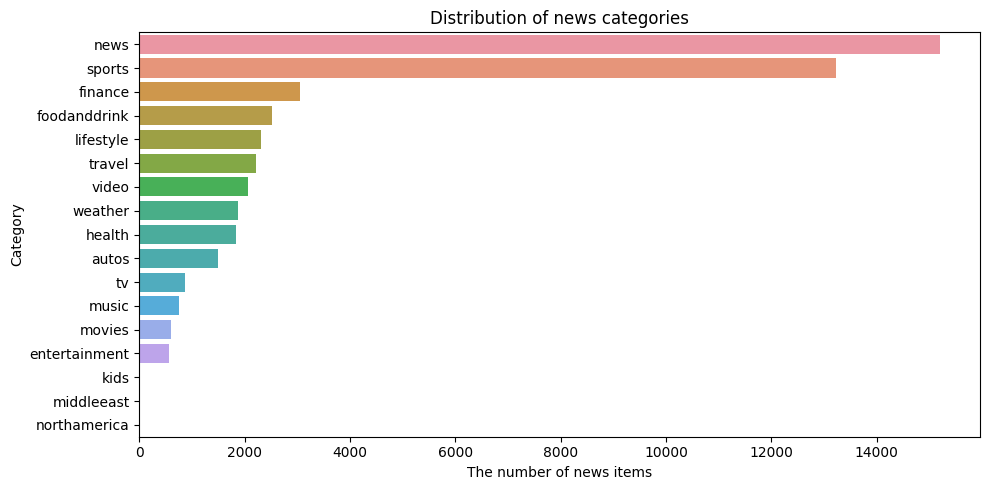

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=news_clean, y='Category', order=news_clean['Category'].value_counts().index)
plt.title('Distribution of news categories')
plt.xlabel('The number of news items')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

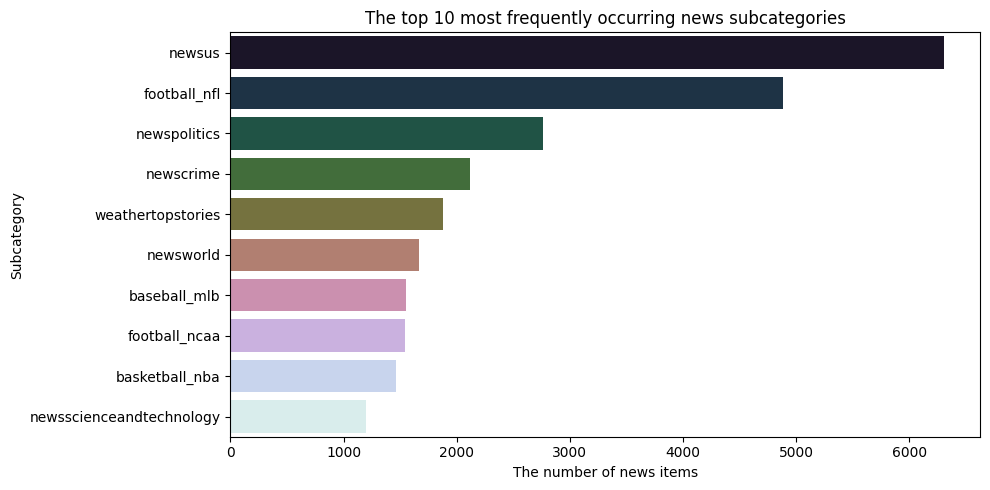

In [20]:
top_subcat = news_clean['SubCategory'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_subcat.values, y=top_subcat.index, palette='cubehelix')
plt.title('The top 10 most frequently occurring news subcategories')
plt.xlabel('The number of news items')
plt.ylabel('Subcategory')
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/3542252221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['title_length'] = news_clean['Title'].apply(lambda x: len(str(x).split()))
/tmp/ipykernel_35/3542252221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['abstract_length'] = news_clean['Abstract'].apply(lambda x: len(str(x).split()))
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf val

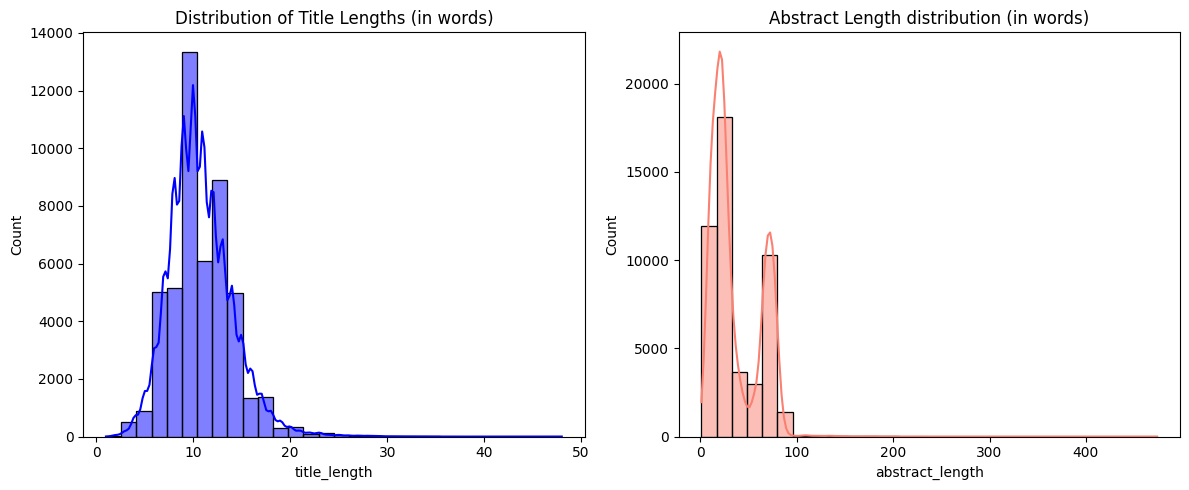

In [21]:
news_clean['title_length'] = news_clean['Title'].apply(lambda x: len(str(x).split()))
news_clean['abstract_length'] = news_clean['Abstract'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(news_clean['title_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Title Lengths (in words)')

plt.subplot(1, 2, 2)
sns.histplot(news_clean['abstract_length'], bins=30, kde=True, color='salmon')
plt.title('Abstract Length distribution (in words)')

plt.tight_layout()
plt.show()

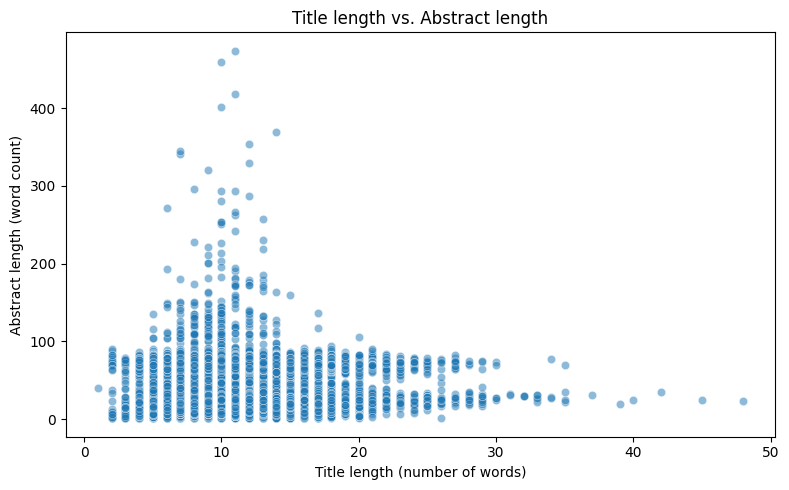

In [22]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=news_clean, x='title_length', y='abstract_length', alpha=0.5)
plt.title('Title length vs. Abstract length')
plt.xlabel('Title length (number of words)')
plt.ylabel('Abstract length (word count)')
plt.tight_layout()
plt.show()

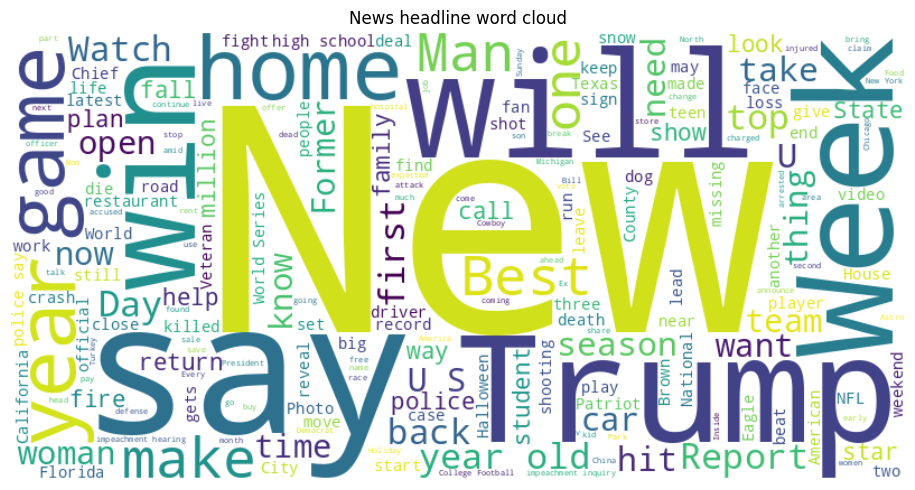

In [23]:
from wordcloud import WordCloud

text_all_titles = ' '.join(news_clean['Title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_all_titles)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('News headline word cloud')
plt.tight_layout()
plt.show()

#### explains

1. **Distribution of News categories**
- Dominant categories: **news** and **sports**
The data distribution is unbalanced
Niche categories (such as *kids*, *middleeast*) belong to the ** long-tail distribution **

2. **Top-10 Subcategories **
The subcategories **newsus**, **football_nfl**, and **baseball_mlb** have the highest occurrence frequency
The *news* category has a high degree of diversity: demonstrating the potential for ** more fine-grained personalized recommendations **

3. Title and Abstract Length
- **Title** : Most are 10 to 15 words
- **Abstract** : Most are 30 to 100 words
For using "TF-IDF" to represent text features, such a length is already quite informative

4. Scatter plot of the lengths of the title and abstract
- No strong correlation: This indicates that the Title and Abstract are complementary information
Support merging the two into 'full_text' as a **joint input feature**

5. "Word Cloud Analysis of News Headlines
- the most common words include: "Trump", "New ", "say", "game", "week"
- The displayed news focuses on politics and sports, which can serve as a basis for themes or entity-level features

# 3. Feature Engineering

### 3.1 Feature Extraction`full_text`

In [24]:
news_clean['full_text'] = news_clean['Title'] + '. ' + news_clean['Abstract']
display(news_clean[['News_ID', 'Category', 'full_text']].head(3))

/tmp/ipykernel_35/729367934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['full_text'] = news_clean['Title'] + '. ' + news_clean['Abstract']


,News_ID,Category,full_text
0,N55528,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,50 Worst Habits For Belly Fat. These seemingly...
2,N61837,news,The Cost of Trump's Aid Freeze in the Trenches...


The design purpose of this merge operation is to combine the brief information (title) with the more complete information (summary) as the input representation in the TF-IDF model. This step is very common in content-based recommendation systems because it can enhance semantic context (Ramos, 2003).

## 3.2. Create interactive df

For the Collaborative Filtering approach, an explicit data structure is required, consisting of User_ID, News_ID, and Label pairs (1 for clicked, 0 for not clicked).
This data is constructed by parsing the Impressions column from the behaviors_clean dataset.

In [29]:
interactions_flat = []

for row in behaviors_clean.itertuples(index=False):  # ALREADY REVISED
    user_id = row.User_ID
    impressions = row.Impressions.split()
    for impression in impressions:
        if '-' in impression:
            news_id, label = impression.rsplit('-', 1)
            interactions_flat.append((user_id, news_id, int(label)))

interactions_df = pd.DataFrame(interactions_flat, columns=['User_ID', 'News_ID', 'Label'])
print("Total interactions:", len(interactions_df))


Total interactions: 5723002


In [31]:
interactions_df

,User_ID,News_ID,Label
0,U13740,N55689,1
1,U13740,N35729,0
2,U91836,N20678,0
3,U91836,N39317,0
4,U91836,N58114,0
...,...,...,...
5722997,U44625,N39317,0
5722998,U64800,N61233,0
5722999,U64800,N33828,1
5723000,U64800,N19661,0


In [32]:
interactions_df.groupby('Label')['Label'].value_counts()

Label
0    5491472
1     231530
Name: count, dtype: int64

In [33]:
news_category = news_clean[['News_ID', 'Category']]
interactions_df = interactions_df.merge(news_category, on='News_ID', how='left')


In [34]:
interactions_df

,User_ID,News_ID,Label,Category
0,U13740,N55689,1,sports
1,U13740,N35729,0,news
2,U91836,N20678,0,sports
3,U91836,N39317,0,news
4,U91836,N58114,0,NaN
...,...,...,...,...
5722997,U44625,N39317,0,news
5722998,U64800,N61233,0,weather
5722999,U64800,N33828,1,movies
5723000,U64800,N19661,0,news


## 3.3. TF-IDF Feature Extraction

As a feature for Content-Based Filtering, text representation is extracted using the TF-IDF (Term Frequency–Inverse Document Frequency) method, which considers word importance based on both local and global occurrence.

In [36]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(news_clean['full_text'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (48612, 5000)


## 3.4. Label Encoding for Collaborative Filtering

In [40]:
user_encoder = LabelEncoder()
news_encoder = LabelEncoder()

interactions_df['user_encoded'] = user_encoder.fit_transform(interactions_df['User_ID'])
interactions_df['news_encoded'] = news_encoder.fit_transform(interactions_df['News_ID'])

num_users = interactions_df['user_encoded'].nunique()
num_items = interactions_df['news_encoded'].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique news items: {num_items}")

Number of unique users: 49108
Number of unique news items: 20252


In [41]:
interactions_df

,User_ID,News_ID,Label,Category,user_encoded,news_encoded
0,U13740,N55689,1,sports,2201,15659
1,U13740,N35729,0,news,2201,8792
2,U91836,N20678,0,sports,47474,3670
3,U91836,N39317,0,news,47474,10061
4,U91836,N58114,0,NaN,47474,16502
...,...,...,...,...,...,...
5722997,U44625,N39317,0,news,20012,10061
5722998,U64800,N61233,0,weather,31669,17625
5722999,U64800,N33828,1,movies,31669,8140
5723000,U64800,N19661,0,news,31669,3330


#### Notes:
Encoding:
- Specific to the architecture of the Collaborative Filtering model
- Encoding depends on the number and distribution of users and items

## 3.5. Data Splitting for Train-Test (training model)

In [42]:
X = interactions_df[['user_encoded', 'news_encoded']]
y = interactions_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Stratified sampling is conducted according to the category ratio of y to ensure that the ratio of positive and negative samples (such as clicked and unclicked) in the training set and the test set remains consistent.

# 4. Experiment

### 4.1. Content Based Filtering - TF-IDF

The Content-Based Filtering approach recommends news based on content similarity between articles, without taking into account the behavior of other users.
News content is represented by transforming the combined text of Title + Abstract into a fixed-dimensional TF-IDF vector.
Then, a k-Nearest Neighbors (k-NN) algorithm based on cosine similarity is used to find the most similar news articles.

In [44]:
# TF-IDF representation based on news content, construct a k-NN model that can identify "similar news" for content recommendation.
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

**metric='cosine'**：
It is used to measure the similarity between vectors, based on the cosine value of the Angle between the vectors.
This method is very common in the similarity calculation of text data (Manning et al., 2008).

**algorithm='brute'**：
It indicates the use of exhaustive (brute force) search, that is, comparing all vectors one by one.
It is suitable for medium-sized datasets because it will slow down when the data volume is too large.

In [45]:
# Mapping from News_ID to DataFrame index
news_index_map = pd.Series(news_clean.index, index=news_clean['News_ID']).to_dict()

def get_recommendations(news_id, top_n=5):
    print("---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---")
    print(news_clean[news_clean['News_ID'] == news_id].values[0][3])  # Print title or abstract
    
    print(f"\n---TOP {top_n} RECOMMENDED NEWS ARTICLES ---")
    idx = news_index_map[news_id]
    tfidf_vector = tfidf_matrix[idx]
    
    distances, knn_indices = model_knn.kneighbors(tfidf_vector, n_neighbors=top_n + 1)
    
    recommendations = news_clean.iloc[knn_indices[0][1:]]  # Exclude the input itself
    return recommendations[['News_ID', 'Title', 'Category', 'URL']]


In [46]:
get_recommendations("N55528", top_n=10)

---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By

---TOP 10 RECOMMENDED NEWS ARTICLES ---


,News_ID,Title,Category,URL
28360,N9056,This Is What Queen Elizabeth Is Doing About th...,lifestyle,https://assets.msn.com/labs/mind/AAJE4rH.html
31743,N38133,The cutest photos of royal children and their ...,lifestyle,https://assets.msn.com/labs/mind/BBVxKU5.html
29974,N60671,Prince Charles Teared Up When Prince William T...,lifestyle,https://assets.msn.com/labs/mind/AAJEWnb.html
38035,N43522,Prince Charles is Getting Into Fashion,lifestyle,https://assets.msn.com/labs/mind/BBWHQ0l.html
35826,N51725,Prince Charles Looks in Awe of Master Archie a...,video,https://assets.msn.com/labs/mind/BBWKLVZ.html
15083,N63823,Prince Charles Hit by One of the Most Incredib...,lifestyle,https://assets.msn.com/labs/mind/AAJT4mB.html
23325,N18530,All the Photos of Prince Charles's Trip to Jap...,lifestyle,https://assets.msn.com/labs/mind/AAJa1La.html
36655,N63174,Prince Albert on Twins Jacques and Gabriella: ...,lifestyle,https://assets.msn.com/labs/mind/BBWHLDG.html
31447,N63495,65 Photos of Prince Charles You've Probably Ne...,lifestyle,https://assets.msn.com/labs/mind/BBPDaWu.html
44779,N57591,Prince Charles Is Getting Into the Fashion Bus...,lifestyle,https://assets.msn.com/labs/mind/BBWF44D.html


### 4.2 Content Based Filtering - Bert

In [51]:
from sentence_transformers import SentenceTransformer, util
import torch

# 1. Load the pre-trained BERT model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# 2. Generate semantic vectors for all news (process and cache them once)
bert_embeddings = model.encode(news_clean['full_text'].tolist(), convert_to_tensor=True)

# 3. Map News_ID to the DataFrame index
news_index_map = pd.Series(news_clean.index, index=news_clean['News_ID']).to_dict()

def get_bert_recommendations(news_id, top_n=5):
    print("---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---")
    
    idx = news_index_map[news_id]
    query_embedding = bert_embeddings[idx]
    
    print(news_clean.iloc[idx]['Title'])  # 打印原始标题
    print("\n---TOP RECOMMENDED ARTICLES---")

    # 6. 计算余弦相似度
    cos_scores = util.cos_sim(query_embedding, bert_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_n + 1)  # +1 是因为自己也在里面

    # 7. 排除自身，返回推荐结果
    recommended_indices = top_results.indices[1:].tolist()
    return news_clean.iloc[recommended_indices][['News_ID', 'Title', 'Category', 'URL']]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1520 [00:00<?, ?it/s]

In [53]:
get_bert_recommendations(news_id='N55528', top_n=10)

---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By

---TOP RECOMMENDED ARTICLES---


,News_ID,Title,Category,URL
392,N42227,Queen Elizabeth's Favorite Beauty Products Hav...,lifestyle,https://assets.msn.com/labs/mind/AAFhHSF.html
15300,N55244,A Brief History of Royals Wearing Denim,lifestyle,https://assets.msn.com/labs/mind/AAIVP5O.html
5052,N23273,Best Looks: Queen Maxima of the Netherlands,lifestyle,https://assets.msn.com/labs/mind/AAC3MfP.html
31387,N19829,﻿﻿Princess Charlene of Monaco Has the Most Dar...,lifestyle,https://assets.msn.com/labs/mind/BBMlsj8.html
1162,N34718,This is Who Can Wear and Borrow the Crown Jewels,lifestyle,https://assets.msn.com/labs/mind/AAHuem1.html
208,N23937,6 gorgeous royal family heirlooms that Kate Mi...,lifestyle,https://assets.msn.com/labs/mind/AAE58ph.html
9787,N39208,21 Things You Never Knew About America's 'Roya...,lifestyle,https://assets.msn.com/labs/mind/AAJF81Z.html
5379,N24668,101 Photos of the Youngest Royals Hanging Out ...,lifestyle,https://assets.msn.com/labs/mind/AAH5YCU.html
3074,N38556,All the times royals have met A-list celebs,entertainment,https://assets.msn.com/labs/mind/AAIsAeV.html
24795,N7898,What the royals would earn in the real world,lifestyle,https://assets.msn.com/labs/mind/AAJzZ9N.html


### 4.3 Collaborative Filtering

The goal of Collaborative Filtering (CF) is to predict a user's interest in a news item based on the interaction patterns of other users with the same item.
In this project, a Model-Based CF approach is used, employing a Neural Collaborative Filtering architecture built with TensorFlow Keras.

The model utilizes embedding representations for users and items (news), which are then combined and passed through several dense layers to predict the probability of a click.

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np


In [78]:
class CFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(CFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, user_input, item_input):
        user_vec = self.user_embedding(user_input)
        item_vec = self.item_embedding(item_input)
        x = torch.cat([user_vec, item_vec], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))
        return x


The model architecture consists of:

Embedding Layer: maps user_id and news_id into a 64-dimensional latent space

Concatenation Layer: combines the user and news representations

Dense Layers: two feedforward layers with 128 and 64 units, using ReLU activation

Output Layer: a single neuron with sigmoid activation to predict binary click/no-click

In [79]:
# 转换为 PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor[:, 0], X_train_tensor[:, 1], y_train_tensor)
test_dataset = TensorDataset(X_test_tensor[:, 0], X_test_tensor[:, 1], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048)


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CFModel(num_users, num_items).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = []
val_losses = []
val_accuracies = []


# EarlyStopping 设置
best_val_loss = float('inf')
patience = 3
counter = 0
best_model_state = None

for epoch in range(10):
    model.train()
    total_loss = 0
    for user, item, label in train_loader:
        user, item, label = user.to(device), item.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(user, item)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 验证
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for user, item, label in test_loader:
            user, item, label = user.to(device), item.to(device), label.to(device)
            outputs = model(user, item)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    acc = accuracy_score((np.array(all_preds) > 0.5).astype(int), np.array(all_labels).astype(int))

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(avg_val_loss)
    val_accuracies.append(acc)
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# 恢复最佳模型
if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1, Train Loss: 362.5978, Val Loss: 0.1569, Val Acc: 0.9595
Epoch 2, Train Loss: 345.5982, Val Loss: 0.1567, Val Acc: 0.9595
Epoch 3, Train Loss: 338.8593, Val Loss: 0.1582, Val Acc: 0.9595
Epoch 4, Train Loss: 332.5568, Val Loss: 0.1602, Val Acc: 0.9595
Epoch 5, Train Loss: 326.2962, Val Loss: 0.1628, Val Acc: 0.9594
Early stopping triggered.


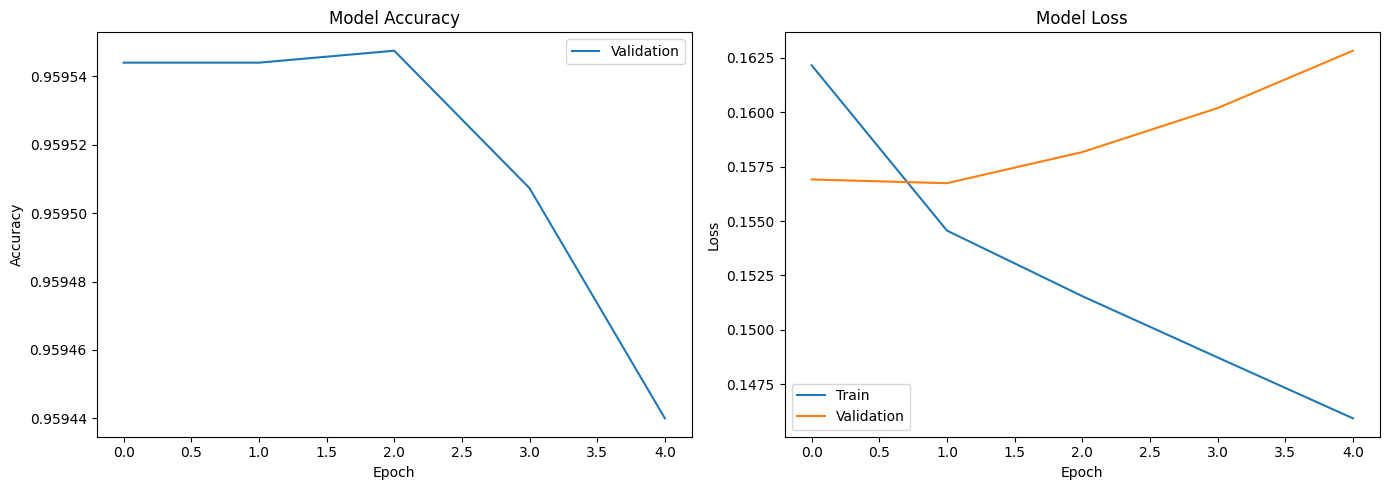

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# 准确率曲线
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 损失曲线
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [84]:
def recommend_for_user(user_id, top_n=5, return_json=False):
    print("---GENERATING NEWS RECOMMENDATIONS FOR USER---")
    print(f"User ID: {user_id}")
    print(f"\n---TOP {top_n} RECOMMENDED NEWS ARTICLES ---")

    # Encode user ID
    user_idx = user_encoder.transform([user_id])[0]
    all_item_indices = np.arange(num_items)

    # Find already clicked items (Label == 1)
    seen_news_ids = interactions_df[
        (interactions_df['User_ID'] == user_id) & 
        (interactions_df['Label'] == 1)
    ]['News_ID'].unique()

    seen_indices = news_encoder.transform(seen_news_ids)
    
    # Filter out seen items
    unseen_mask = ~np.isin(all_item_indices, seen_indices)
    unseen_items = all_item_indices[unseen_mask]

    # Skip if nothing to recommend
    if len(unseen_items) == 0:
        print("No unseen items to recommend.")
        return pd.DataFrame()

    # Prepare input tensors
    user_tensor = torch.tensor([user_idx] * len(unseen_items), dtype=torch.long).to(device)
    item_tensor = torch.tensor(unseen_items, dtype=torch.long).to(device)

    # Predict scores
    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy().flatten()

    # Get top-N
    top_indices = np.argsort(-scores)[:top_n]
    top_item_ids = news_encoder.inverse_transform(unseen_items[top_indices])

    # Retrieve actual news info
    recommended = news[news['News_ID'].isin(top_item_ids)][['News_ID', 'Title', 'Category', 'SubCategory']]

    # Optional JSON return
    if return_json:
        return recommended.to_dict(orient='records')
    
    return recommended


In [85]:
recommend_for_user("U64800", top_n=10)


---GENERATING NEWS RECOMMENDATIONS FOR USER---
User ID: U64800

---TOP 10 RECOMMENDED NEWS ARTICLES ---


,News_ID,Title,Category,SubCategory
34634,N54489,Fast food cashier and manager fired for refusi...,news,newsus
37026,N60750,"Browns, Steelers brawl at end of Cleveland's 2...",sports,football_nfl
41384,N30714,Sarasota woman accused of killing her mother b...,news,newscrime
42344,N46071,Report: Kings point guard De'Aaron Fox suffers...,sports,basketball_nba
47728,N40135,'That's A Lot Of Mental Scar Tissue': Patriots...,sports,football_nfl
50365,N49279,Broadway Actress Laurel Griggs Dies at Age 13,music,musicnews
50459,N350,A Russian professor was pulled from a river. P...,news,newsworld
50714,N49685,Broadway Star Laurel Griggs Suffered Asthma At...,music,music-celebrity
50958,N39663,Cris Collinsworth made mistake with mention of...,sports,football_nfl
51000,N42922,AP Top 25: LSU landslide No. 1; Minnesota jump...,sports,football_ncaa


# 5. Evaluate Model

The evaluation of the recommendation system is conducted to assess how relevant the suggested news articles are to the users.
Since this project focuses on implicit feedback (click or no click), the evaluation uses predictive relevance metrics, rather than classic accuracy metrics.

In [86]:
interactions_df

,User_ID,News_ID,Label,Category,user_encoded,news_encoded
0,U13740,N55689,1,sports,2201,15659
1,U13740,N35729,0,news,2201,8792
2,U91836,N20678,0,sports,47474,3670
3,U91836,N39317,0,news,47474,10061
4,U91836,N58114,0,NaN,47474,16502
...,...,...,...,...,...,...
5722997,U44625,N39317,0,news,20012,10061
5722998,U64800,N61233,0,weather,31669,17625
5722999,U64800,N33828,1,movies,31669,8140
5723000,U64800,N19661,0,news,31669,3330


In [88]:
from collections import defaultdict

user_categories = defaultdict(set)

for row in interactions_df.itertuples(index=False):
    if row.Label == 1 and pd.notnull(row.Category):
        user_categories[row.User_ID].add(row.Category)


### Evaluation Metric: Precision@K Based on Historical Categories


The main evaluation metric used is **Precision@K**, which measures the proportion of the _top-K_ recommended news articles that **belong to the same categories** as those previously clicked by the user.

This approach is considered more realistic for a news recommendation system because:

- Users tend to consume news from categories they are interested in.
- Not clicking a news article doesn't necessarily mean it's irrelevant.

**Formula:**

$$
\text{Precision@K} = \dfrac{\text{Number of Recommended Items Matching User's History}}{K}
$$


In [91]:
def precision_by_category(predicted_news_ids, user_id, news_df, user_category_map, k=5):
    user_category_set = user_category_map.get(user_id, set())
    if not user_category_set:
        return 0.0

    predicted_categories = news_df.loc[
        news_df['News_ID'].isin(predicted_news_ids[:k]), 'Category'
    ]

    hits = sum([1 for category in predicted_categories if category in user_category_set])
    return hits / k


## 5.1. Evaluate CBF - tfidf

In [93]:
def evaluate_cbf_precision(k=5, n_samples=100):
    total_precision = 0
    valid_user_count = 0

    # Sample subset of users
    sampled_users = interactions_df['User_ID'].unique()[:n_samples]
    
    for user_id in sampled_users:
        if user_id not in user_categories:
            continue

        # Get user's clicked news
        user_clicked = interactions_df[
            (interactions_df['User_ID'] == user_id) &
            (interactions_df['Label'] == 1)
        ]

        # Use the most recent clicked news as the reference
        last_clicked_news = user_clicked['News_ID'].values[-1] if not user_clicked.empty else None

        if last_clicked_news and last_clicked_news in news_index_map:
            try:
                # Generate content-based recommendations
                recommendations = get_recommendations(last_clicked_news, top_n=k)['News_ID'].values

                # Evaluate how many recommended news match user's historical categories
                precision = precision_by_category(
                    recommendations, user_id, news_clean, user_categories, k=k
                )

                total_precision += precision
                valid_user_count += 1
            except:
                continue

    return total_precision / valid_user_count if valid_user_count > 0 else 0.0


cbf_precision_at_k = evaluate_cbf_precision(k=10, n_samples=50)
print(cbf_precision_at_k)

---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
George Kent, top State Department Ukraine expert, helps Democrats debunk GOP theories

---TOP 10 RECOMMENDED NEWS ARTICLES ---
---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
Multistate police pursuit ends on Cane Run Road

---TOP 10 RECOMMENDED NEWS ARTICLES ---
---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
49ers: Joe Staley could miss time with new injury; Ronald Blair out for season

---TOP 10 RECOMMENDED NEWS ARTICLES ---
---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
The son of a Chinese billionaire has been banned from flying first class, playing golf, buying property, or going clubbing

---TOP 10 RECOMMENDED NEWS ARTICLES ---
---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
These are the new cars that depreciate least

---TOP 10 RECOMMENDED NEWS ARTICLES ---
---GENERATING RECOMMENDATIONS FOR NEWS ARTICLE---
Cashman: Yankees will pursue free agents Cole, Strasburg

---TOP 10 RECOMMENDED NEWS ARTICLES ---
---GENERATING RE

In [96]:
print(f"Precision@10 CBF-tfidf: {cbf_precision_at_k:.4f}")

Precision@10 CBF-tfidf: 0.4872


In [97]:
def evaluate_bert_precision(k=5, n_samples=100):
    total_precision = 0
    valid_user_count = 0

    # Sample a subset of users
    sampled_users = interactions_df['User_ID'].unique()[:n_samples]

    for user_id in sampled_users:
        if user_id not in user_categories:
            continue

        # Get user's clicked news
        user_clicked = interactions_df[
            (interactions_df['User_ID'] == user_id) &
            (interactions_df['Label'] == 1)
        ]

        # Use the most recent clicked news as the reference
        last_clicked_news = user_clicked['News_ID'].values[-1] if not user_clicked.empty else None

        if last_clicked_news and last_clicked_news in news_index_map:
            try:
                # Generate BERT-based recommendations
                recommendations_df = get_bert_recommendations(last_clicked_news, top_n=k)
                recommended_ids = recommendations_df['News_ID'].values

                # Compute precision@k based on user historical categories
                precision = precision_by_category(
                    recommended_ids, user_id, news_clean, user_categories, k=k
                )

                total_precision += precision
                valid_user_count += 1
            except:
                continue

    return total_precision / valid_user_count if valid_user_count > 0 else 0.0

# Example usage
bert_precision_at_k = evaluate_bert_precision(k=10, n_samples=50)


---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
Fleck won't compromise his unique style as he leads Minnesota to rare heights

---TOP RECOMMENDED ARTICLES---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
Freddie Kitchens discusses Browns win in Sunday postgame press conference: Transcript

---TOP RECOMMENDED ARTICLES---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
How To Protect Yourself From Hackers While Holiday Shopping Online

---TOP RECOMMENDED ARTICLES---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
Ringo Starr says new album likely to be his last

---TOP RECOMMENDED ARTICLES---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
Amazing motorhomes of the rich and famous

---TOP RECOMMENDED ARTICLES---
---GENERATING BERT-BASED RECOMMENDATIONS FOR NEWS ARTICLE---
'ALS is a monster': Two men wi

In [98]:
print(f"Precision@10 CBF-Bert: {bert_precision_at_k:.4f}")

Precision@10 CBF-Bert: 0.4795


## 5.2. Evaluate CF

In [99]:
def evaluate_cf_precision(model, k=5, n_samples=100):
    model.eval()
    total_precision = 0
    valid_user_count = 0

    sampled_users = interactions_df['User_ID'].unique()[:n_samples]

    for user_id in sampled_users:
        if user_id not in user_categories:
            continue

        try:
            # Encode user ID
            user_idx = user_encoder.transform([user_id])[0]
            all_item_indices = np.arange(num_items)

            user_tensor = torch.tensor([user_idx] * num_items, dtype=torch.long).to(device)
            item_tensor = torch.tensor(all_item_indices, dtype=torch.long).to(device)

            # Predict with trained model
            with torch.no_grad():
                scores = model(user_tensor, item_tensor).cpu().numpy().flatten()

            # Get top-K item indices
            top_indices = np.argsort(-scores)[:k]
            recommended_news_ids = news_encoder.inverse_transform(top_indices)

            # Compute precision based on category match
            precision = precision_by_category(
                recommended_news_ids, user_id, news_clean, user_categories, k=k
            )

            total_precision += precision
            valid_user_count += 1

        except:
            continue

    return total_precision / valid_user_count if valid_user_count > 0 else 0.0

# Example usage:
cf_precision_at_k = evaluate_cf_precision(model, k=10, n_samples=50)


In [100]:
cf_precision_at_k

0.49183673469387756

In [98]:
def cf_precision_at_k(k=5, n_samples = 50):
    total_prec_cf = 0
    count_cf = 0
    user_sample = interaksi_df['User_ID'].unique()[:n_samples]  
    
    for user_id in user_sample:
        if user_id not in kategori_user:
            continue
    
        try:
            user_idx = user_encoder.transform([user_id])[0]
        except:
            continue  
    
        semua_berita = np.arange(num_items)
        user_array = np.full_like(semua_berita, user_idx)
    
        prediksi = model.predict([user_array, semua_berita], verbose=0).flatten()
        top_idx = np.argsort(-prediksi)[:k]
        news_ids_pred = news_encoder.inverse_transform(top_idx)
    
        skor = precision_kategori(news_ids_pred, user_id, news_clean, kategori_user, k=5)
        total_prec_cf += skor
        count_cf += 1
    
    return total_prec_cf / count_cf

cf_precision_at_10 = cf_precision_at_k(k=10, n_samples=50)

In [99]:
print(f"Precision@10 CF (berbasis kategori historis): {cf_precision_at_10:.4f}")

Precision@10 CF (berbasis kategori historis): 0.4857


### Result

### Precision@10 Comparison Table

| Model                         | Precision@10 |
|------------------------------|--------------|
| Content-Based (TF-IDF)       | 0.4872       |
| Content-Based (BERT)         | 0.4795       |
| Collaborative Filtering (CF Based on Model) | **0.4918**   |
